<a href="https://colab.research.google.com/github/TomK-cpu/tensor-ai-site/blob/main/ZINC22_downloads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading molecule tranches from the ZINC22 Database for virtual screening

ZINC-22 is a free database of commercially-available compounds for virtual screening. ZINC-22 focuses on make-on-demand ("tangible") compounds from a small number of large catalogs: Enamine, WuXi and Mcule. ZINC-22 currently has about 54.9 billion molecules in 2D and 5.9 billion in 3D.

Cartblanche22 is an interface to ZINC-22. We'll be getting out molecules from https://cartblanche22.docking.org/tranches/2d

A tutorial can be foudn at https://www.youtube.com/watch?v=OE2sBQ61LEg&t=7s

In [7]:
#@title 1) Install modern RDKit + friends (works on Colab Py 3.12)
!pip -q install "rdkit>=2024.9" "numpy>=2.0,<3" pandas pillow ipywidgets matplotlib mols2grid tqdm

# 2) Sanity check
from google.colab import output
output.enable_custom_widget_manager()

import sys, numpy as np, pandas as pd
from rdkit import rdBase, Chem
print("Python:", sys.version.split()[0])
print("NumPy :", np.__version__)
print("RDKit :", getattr(rdBase, "rdkitVersion", "unknown"))
assert Chem.MolFromSmiles("CCO")
print("RDKit import OK ✓")


Python: 3.12.11
NumPy : 2.0.2
RDKit : 2025.03.5
RDKit import OK ✓


In [2]:
#@title path to the .wget file you uploaded
%%bash
SCRIPT="/content/ZINC22-downloader-2D-smi.gz.wget"
OUT_DIR="/content/zinc22_raw"
sed -i 's/\r$//' "$SCRIPT"
mkdir -p "$OUT_DIR" && cd "$OUT_DIR"
bash "$SCRIPT"

mkdir: created directory 'H16'


--2025-08-26 00:27:02--  https://files.docking.org/zinc22/vendors_zincid_map/current/H16/H16P030.smi.gz
Resolving files.docking.org (files.docking.org)... 169.230.75.4
Connecting to files.docking.org (files.docking.org)|169.230.75.4|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="Restricted Content"
Reusing existing connection to files.docking.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 44273081 (42M) [application/x-gzip]
Saving to: ‘H16/H16P030.smi.gz’

     0K .......... .......... .......... .......... ..........  0%  357K 2m1s
    50K .......... .......... .......... .......... ..........  0%  725K 90s
   100K .......... .......... .......... .......... ..........  0%  728K 80s
   150K .......... .......... .......... .......... ..........  0% 79.8M 60s
   200K .......... .......... .......... .......... ..........  0% 59.5M 48s
   250K .......... .......... .......... .......... ..........  0%  7

In [5]:
#@title Preview ZINC-22 downloads (handles .smi.tgz, .smi.gz, .smi; recursive)

import io, tarfile, gzip, glob, os, pandas as pd
from rdkit import Chem
import mols2grid
from IPython.display import display

ROOT = "/content/zinc22_raw"   # where you downloaded
N_PREVIEW = 10000               # molecules for the grid

def iter_all_smiles(root):
    """Yield SMILES from any .smi.tgz / .smi.gz / .smi under root (recursive)."""
    # 1) .smi.tgz archives
    for tgz in glob.glob(os.path.join(root, "**", "*.smi.tgz"), recursive=True):
        with tarfile.open(tgz, "r:gz") as tf:
            for m in tf.getmembers():
                if not m.isfile() or not (m.name.endswith(".smi") or m.name.endswith(".smi.gz")):
                    continue
                f = tf.extractfile(m)
                if f is None:
                    continue
                if m.name.endswith(".gz"):
                    f = gzip.GzipFile(fileobj=f)
                for line in io.TextIOWrapper(f, encoding="utf-8", errors="ignore"):
                    line=line.strip()
                    if line and not line.startswith("#"):
                        yield line.split()[0]

    # 2) loose .smi.gz files
    for gz_path in glob.glob(os.path.join(root, "**", "*.smi.gz"), recursive=True):
        with gzip.open(gz_path, "rt", encoding="utf-8", errors="ignore") as f:
            for line in f:
                line=line.strip()
                if line and not line.startswith("#"):
                    yield line.split()[0]

    # 3) loose .smi files
    for smi_path in glob.glob(os.path.join(root, "**", "*.smi"), recursive=True):
        with open(smi_path, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                line=line.strip()
                if line and not line.startswith("#"):
                    yield line.split()[0]

# Collect preview molecules
rows = []
for smi in iter_all_smiles(ROOT):
    m = Chem.MolFromSmiles(smi)
    if m:
        rows.append({"mol": m, "smiles": smi})
    if len(rows) >= N_PREVIEW:
        break

if rows:
    df = pd.DataFrame(rows)
    display(mols2grid.display(df, mol_col="mol", smiles_col="smiles",
                              subset=["img","smiles"], use_svg=True, n_cols=6))
    print(f"Previewed {len(df)} molecules. "
          f"Scanned {len(glob.glob(ROOT + '/**/*.smi*', recursive=True))} files under {ROOT}.")
else:
    print("No molecules parsed — check the download folder and file types.")


MolGridWidget()

Previewed 10000 molecules. Scanned 1 files under /content/zinc22_raw.


Now you can select the molecules (or select all) and save them as a CSV. If they need to be converted to ligands.txt format for PocketVina, simply use the script below.

In [ ]:
# @title Convert CSV → PocketVina ligands.txt (auto-detect delimiter)
from pathlib import Path
import csv

# ====== SETTINGS ======
INPUT_CSV  = "/content/outputs/selection (9).csv"  # change if needed
OUTPUT_TXT = "/content/ligands.txt"
ID_COL     = "index"     # use your 'index' column as molecule_name; set to None to auto-number
DROP_MISSING_SMILES = True
DROP_DUP_SMILES     = False
MAX_ROWS = None
# ======================

def detect_delimiter(path):
    with open(path, "r", encoding="utf-8-sig", newline="") as f:
        sample = f.read(65536)
    for d in [",",";","\t","|"]:
        if sample.splitlines()[0].count(d) > 0:
            return d
    try:
        return csv.Sniffer().sniff(sample, delimiters=[",",";","\t","|"]).delimiter
    except Exception:
        return ","

def find_col_idx(headers, target="smiles"):
    norm = [h.strip().lower() for h in headers]
    # exact matches first
    for k in ["smiles", "canonical_smiles"]:
        if k in norm:
            return norm.index(k)
    # any header that contains 'smiles'
    for i, h in enumerate(norm):
        if "smiles" in h:
            return i
    return None

in_path = Path(INPUT_CSV)
if not in_path.exists():
    # Auto-pick or upload
    csv_files = list(Path("/content").glob("*.csv"))
    if len(csv_files) == 1:
        in_path = csv_files[0]
        print(f"Auto-selected: {in_path}")
    else:
        from google.colab import files
        print("Upload your .csv file…")
        uploaded = files.upload()
        in_path = Path(next(iter(uploaded.keys())))

delimiter = detect_delimiter(in_path)

with open(in_path, "r", encoding="utf-8-sig", newline="") as fin:
    reader = csv.reader(fin, delimiter=delimiter)
    headers = next(reader)
    smiles_idx = find_col_idx(headers, "smiles")
    if smiles_idx is None:
        raise ValueError(
            f"No 'smiles' column found. Headers: {headers} (detected delimiter '{delimiter}')"
        )
    id_idx = None
    if ID_COL:
        norm = [h.strip().lower() for h in headers]
        if ID_COL.lower() in norm:
            id_idx = norm.index(ID_COL.lower())

    rows = []
    for idx, row in enumerate(reader):
        if MAX_ROWS and len(rows) >= MAX_ROWS:
            break
        smi = (row[smiles_idx] if smiles_idx < len(row) else "").strip()
        if not smi and DROP_MISSING_SMILES:
            continue
        name = (row[id_idx].strip() if id_idx is not None and id_idx < len(row) else str(idx))
        name = name.replace(",", "_")
        rows.append((name, smi))

# de-dup if requested
if DROP_DUP_SMILES:
    seen, uniq = set(), []
    for name, smi in rows:
        if smi in seen:
            continue
        seen.add(smi)
        uniq.append((name, smi))
    rows = uniq

# if not using an ID column, renumber 0..N-1
if ID_COL is None:
    rows = [(str(i), smi) for i, (_, smi) in enumerate(rows)]

out_path = Path(OUTPUT_TXT)
out_path.parent.mkdir(parents=True, exist_ok=True)
with open(out_path, "w", encoding="utf-8", newline="") as fout:
    w = csv.writer(fout)
    w.writerow(["molecule_name", "smiles"])
    w.writerows(rows)

print(f"Detected delimiter: '{delimiter}'")
print(f"SMILES header: {headers[smiles_idx]}")
print(f"Read {len(rows)} molecules from: {in_path.resolve()}")
print(f"Wrote: {out_path.resolve()}")

print("\nPreview:")
with open(out_path, "r", encoding="utf-8") as f:
    for _ in range(6):
        line = f.readline().rstrip()
        if not line: break
        print(line)


Detected delimiter: ';'
SMILES header: smiles
Read 53 molecules from: /content/outputs/selection (9).csv
Wrote: /content/ligands.txt

Preview:
molecule_name,smiles
31,CN(C)C(=O)C1CN(N2CCOCC2)CC1c1cccc2ccccc12
40,c1ccc(OCC2CN(N3CCOCC3)CC2n2cnnn2)cc1
991,c1cnc2ccc(C3CN(N4CCOCC4)CC3n3cnnn3)cc2c1
317,CN(C)C(=O)C1CN(CCCO)CC1c1ccccn1
32,CN(C)C(=O)C1CN(N2CCC(O)CC2)CC1COc1ccccc1


# Creating new chemical-space: core decoration using chemical intuition

*   What if instead of virtually screening these 1,087,310 ZINC22 fragments (/content/zinc22_raw/H16/H16P030.smi.gz), we wanted to use them as building blocks to decorate our pyrroldine cores?

* Let's remind ourselves of the structures again, as well as our chosen exit vectors and their chemical reactivities:

1. **Exit 3 (the pyrrolidine N) is a nucleophile.**
In practice you would decorate it with electrophiles: carboxylic acids (as amides via activation), acyl/alkyl chloro/fluoro‐derivatives (acyl chlorides, sulfonyl chlorides, chloroformates), activated carbonates, isocyanates (→ ureas), and primary alkyl halides / sulfonates for N-alkylation.

2. **Exit 1 (a ring sp³ carbon) is not a generic “attach anything” site.** To form a realistic C–X or C–C bond you need a defined disconnection:

* If you want C–N / C–O / C–S there, the core would normally bear a leaving group at that carbon (–Cl/–Br/–I, –OTs/–OMs) and you’d react with an external nucleophile (alcohol/amine/thiol) via SN2 (or a radical/SN1 variant).

* If you want C–C, that typically means cross-coupling (the core carbon or the fragment must be a halide/boron/zinc, etc.) or a radical addition (e.g., Giese / Michael). An arbitrary “single-bond attach” isn’t a synthetic plan.

SMILES 1: [*][C@H]1[C@H](C(O)=O)CN(C([*])=O)C1  SMILES 2: [*][C@H]1[C@H](CO)CN(C([*])=O)C1


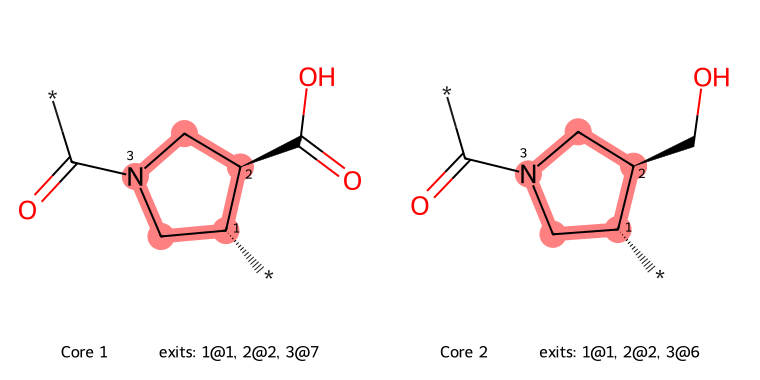

In [ ]:
#@title Label all exit vectors from the pyrrolidine core

from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import display

# Your two core templates (with explicit '*' exits)
print("SMILES 1: [*][C@H]1[C@H](C(O)=O)CN(C([*])=O)C1",
      " SMILES 2: [*][C@H]1[C@H](CO)CN(C([*])=O)C1")

smiles_list = [
    "[*][C@H]1[C@H](C(O)=O)CN(C([*])=O)C1",
    "[*][C@H]1[C@H](CO)CN(C([*])=O)C1"
]

# Core definition consistent with the generator
CORE_SMARTS = [
    "[NX3;H0]1CCCC1",   # tertiary ring N
    "[NX3;H1]1CCCC1"    # secondary ring N (protonated/neutral)
]

def label_core_exits_on_core_atoms(smi, core_smarts=CORE_SMARTS):
    """
    Find the pyrrolidine core, detect all boundary bonds (exits),
    and put numeric labels (1,2,...) as 'atomNote' on the *core atoms*
    where each exit leaves the ring.

    Returns: (labeled molecule, core_atom_indices, exit_map)
      - exit_map: list of tuples (label, core_atom_idx, neighbor_idx)
    """
    m = Chem.MolFromSmiles(smi)
    if m is None:
        raise ValueError(f"Failed to parse: {smi}")

    # match the core
    best = None
    for s in core_smarts:
        q = Chem.MolFromSmarts(s)
        hits = m.GetSubstructMatches(q) if q else ()
        if hits:
            best = hits[0]; break
    if best is None:
        raise ValueError("Pyrrolidine core not found in this SMILES.")

    core_set = set(best)

    # find boundary bonds (one atom in core, the other outside)
    exits = []
    for b in m.GetBonds():
        a, c = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        inA, inC = (a in core_set), (c in core_set)
        if inA ^ inC:
            core_idx   = a if inA else c
            neigh_idx  = c if inA else a
            exits.append((core_idx, neigh_idx, b.GetIdx()))

    # deterministic order: sort by (core atom index, neighbor atom index)
    exits.sort(key=lambda t: (t[0], t[1]))

    # apply labels (1..n) on the core atoms; if multiple exits from same atom, join "1,3"
    labels_by_core_atom = {}
    exit_map = []
    for i, (core_idx, neigh_idx, bond_idx) in enumerate(exits, start=1):
        labels_by_core_atom.setdefault(core_idx, []).append(i)
        exit_map.append((i, core_idx, neigh_idx))

    # clear any previous notes / map numbers
    for a in m.GetAtoms():
        if a.HasProp("atomNote"): a.ClearProp("atomNote")
        if a.GetAtomMapNum(): a.SetAtomMapNum(0)

    # set notes on the core atoms
    for core_idx, nums in labels_by_core_atom.items():
        m.GetAtomWithIdx(core_idx).SetProp("atomNote", ",".join(map(str, nums)))

    # nice 2D coords
    rdDepictor.Compute2DCoords(m)
    return m, list(core_set), exit_map

# Build labeled molecules and collect highlights
labeled_mols, highlights, legends = [], [], []
for i, smi in enumerate(smiles_list, start=1):
    mol, core_atoms, exit_map = label_core_exits_on_core_atoms(smi)

    # optional: gray-highlight the core ring so exits are obvious
    highlights.append(core_atoms)
    legends.append(f"Core {i} — exits: " + ", ".join([f"{lab}@{core}" for lab, core, _ in exit_map]))
    labeled_mols.append(mol)

# Draw side-by-side (PNG) inline
# Use atomNote to show labels; also highlight the core ring atoms lightly.
highlight_atom_lists = highlights
img = Draw.MolsToGridImage(
    labeled_mols,
    molsPerRow=2,
    subImgSize=(380, 380),
    legends=legends,
    highlightAtomLists=highlight_atom_lists,
    useSVG=False
)
display(img)


So for library mining from ZINC, a sensible split is:

1. **Electrophiles for Exit 3 (N-acylation/alkylation):**
acids (as amide precursors), acyl/sulfonyl chlorides or fluorides, chloroformates, isocyanates, primary alkyl halides/mesylates/tosylates, allylic/benzylic halides.

2. **Nucleophiles for Exit 1 (SN2 on a core C–LG):**
aliphatic alcohols, phenols, primary/secondary (non-amide) amines, thiols.
(If you instead want C–C at exit-1, mine primary alkyl halides/boronates/vinyl/aryl halides and plan a coupling recipe.)

Below is a Colab-ready scanner that goes through your downloaded ZINC folder and writes two sets:

* `electrophiles_for_exit3.smi` — things that can react with the pyrrolidine N

* `nucleophiles_for_exit1.smi` — things that can react with a C–LG at exit-1

It also previews a small sample with mols2grid.


In [8]:
#@title Find electrophiles for Exit 3 (N) and nucleophiles for Exit 1 (C–LG)
import os, io, glob, tarfile, gzip
import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
import mols2grid
from IPython.display import display

ROOT = "/content/zinc22_raw"   # your download root (recursive)
PREVIEW_N = 800

OUT_E3 = "/content/electrophiles_for_exit3.smi"
OUT_E1 = "/content/nucleophiles_for_exit1.smi"

def iter_all_smiles(root):
    # .smi.tgz → stream internal .smi / .smi.gz
    for tgz in glob.glob(os.path.join(root, "**", "*.smi.tgz"), recursive=True):
        with tarfile.open(tgz, "r:gz") as tf:
            for m in tf.getmembers():
                if not m.isfile() or not (m.name.endswith(".smi") or m.name.endswith(".smi.gz")):
                    continue
                f = tf.extractfile(m)
                if f is None: continue
                if m.name.endswith(".gz"):
                    f = gzip.GzipFile(fileobj=f)
                for line in io.TextIOWrapper(f, encoding="utf-8", errors="ignore"):
                    line=line.strip()
                    if line and not line.startswith("#"):
                        yield line.split()[0]
    # loose .smi.gz
    for gz in glob.glob(os.path.join(root, "**", "*.smi.gz"), recursive=True):
        with gzip.open(gz, "rt", encoding="utf-8", errors="ignore") as f:
            for line in f:
                line=line.strip()
                if line and not line.startswith("#"):
                    yield line.split()[0]
    # loose .smi
    for fn in glob.glob(os.path.join(root, "**", "*.smi"), recursive=True):
        with open(fn, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                line=line.strip()
                if line and not line.startswith("#"):
                    yield line.split()[0]

# SMARTS panels
# Electrophiles for Exit 3 (N): acids + “activated” electrophiles + primary alkyl halides/sulfonates
E3_PATTS = {
    "carboxylic_acid"  : Chem.MolFromSmarts("[CX3](=O)[OX2H]"),
    "sulfonic_acid"    : Chem.MolFromSmarts("S(=O)(=O)[OX2H]"),
    "acyl_chloride"    : Chem.MolFromSmarts("[CX3](=O)Cl"),
    "acyl_fluoride"    : Chem.MolFromSmarts("[CX3](=O)F"),
    "sulfonyl_chloride": Chem.MolFromSmarts("S(=O)(=O)Cl"),
    "chloroformate"    : Chem.MolFromSmarts("[OX2][CX3](=O)Cl"),
    "isocyanate"       : Chem.MolFromSmarts("N=C=O"),
    "alkyl_halide_P"   : Chem.MolFromSmarts("[CH2][Cl,Br,I]"),         # primary
    "alkyl_sulfonate"  : Chem.MolFromSmarts("[OX2]S(=O)(=O)[Cl,N,O,c]") # tosyl/mesyl/others
}

# Nucleophiles for Exit 1 (to react with a C–LG on the core)
E1_PATTS = {
    "aliphatic_alcohol": Chem.MolFromSmarts("[OX2H][CX4]"),
    "phenol"           : Chem.MolFromSmarts("[OX2H]c"),
    "primary_amine"    : Chem.MolFromSmarts("[NX3H2;!$(NC=O)]"),
    "secondary_amine"  : Chem.MolFromSmarts("[NX3H;!$(NC=O)]"),
    "thiol"            : Chem.MolFromSmarts("[SX2H]"),
    # comment out if you do NOT want anilines:
    "aniline"          : Chem.MolFromSmarts("[NX3;H2,H1]-c")
}

def any_match(mol, patt_dict):
    return any(mol.HasSubstructMatch(p) for p in patt_dict.values())

e3, e1, preview = [], [], []

for smi in tqdm(iter_all_smiles(ROOT), desc="Scanning", unit="mol"):
    m = Chem.MolFromSmiles(smi)
    if not m:
        continue
    hit_e3 = any_match(m, E3_PATTS)
    hit_e1 = any_match(m, E1_PATTS)
    if hit_e3: e3.append(smi)
    if hit_e1: e1.append(smi)
    if (hit_e3 or hit_e1) and len(preview) < PREVIEW_N:
        tag = ",".join([t for t, p in (("E3", hit_e3), ("E1", hit_e1)) if p])
        preview.append({"mol": m, "smiles": smi, "tag": tag})

with open(OUT_E3, "w") as f: f.writelines(s + "\n" for s in e3)
with open(OUT_E1, "w") as f: f.writelines(s + "\n" for s in e1)

print(f"Exit-3 electrophiles: {len(e3):,}  → {OUT_E3}")
print(f"Exit-1 nucleophiles:  {len(e1):,}  → {OUT_E1}")

if preview:
    df = pd.DataFrame(preview)
    display(mols2grid.display(df, mol_col="mol", smiles_col="smiles",
                              subset=["img","tag","smiles"], use_svg=True, n_cols=6))


Scanning: 0mol [00:00, ?mol/s]

Exit-3 electrophiles: 180,558  → /content/electrophiles_for_exit3.smi
Exit-1 nucleophiles:  1,497,800  → /content/nucleophiles_for_exit1.smi


MolGridWidget()

If you decide which chemistry you want at each exit (e.g., “amide at exit-3, ether at exit-1”), you can use the exact RDKit reaction SMARTS + a small enumerator that takes your core(s) and these mined sets and produces only synthetically sensible products.

*   If you want chemistry-faithful enumeration, use RDKit reactions with these pools:

* N-acylation (amide):
`[#7:1].[C:2](=O)O[H] >> [#7:1][C:2](=O)`

* N-sulfonylation:
`[#7:1].S(=O)(=O)O[H] >> [#7:1]S(=O)(=O)`

* N-alkylation (SN2, primary):
`[#7:1].[CH2:2][Br,Cl,I] >> [#7:1][CH2:2]`

* C(sp³)–O/N/S at exit-1 (SN2): first virtually install a leaving group on exit-1 (e.g., convert exit-1 to –CH2Br), then react with the E1 nucleophile set.

*   If you keep reaction-agnostic “single-bond attach” enumeration, you’ll still get valence-correct products but not necessarily realistic transforms.

